In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [16]:
def kl_div(A, B):
    n = A.shape[0]
    return 0.5 * (np.trace(np.linalg.solve(B, A)) - n + np.linalg.slogdet(B)[1] - np.linalg.slogdet(A)[1])

def reverse_maximin(points):
    n = np.shape(points)[0]
    indices = np.zeros(n, dtype=int)
    lengths = np.zeros(n, dtype=float)
    dists = np.linalg.norm(points - points[0], axis=1)
    indices[-1] = 0
    lengths[0] = np.inf
    for i in range(n - 2, -1, -1):
        k = np.argmax(dists)
        indices[i] = k
        lengths[i] = dists[k]
        dists = np.minimum(dists, np.linalg.norm(points[k] - points, axis=1))
    return indices, lengths

def maximin(points):
    order = reverse_maximin(points)[0]
    return order[::-1]

def distance_order(points, idx):
    # order the points by distance to the point at index idx
    dists = np.linalg.norm(points - points[idx], axis=1)
    order = np.argsort(dists)
    return order

In [17]:
with open('10x10x10iso1024.pickle', 'rb') as f:
    data = pickle.load(f)

In [35]:
nx = 10
ny = 10
nz = 10
# x_points = np.linspace(0.0, 18 * np.pi / 1024, nx, dtype = np.float64)
x_points = np.linspace(0.0, 18 * np.pi / 512, nx, dtype = np.float64)
# y_points = np.pi / 2
y_points = np.linspace(0.0, 18 * np.pi / 512, ny, dtype = np.float64)
# z_points = np.linspace(0.0, 18 * np.pi / 1024, nz, dtype = np.float64)
z_points = np.linspace(0.0, 18 * np.pi / 512, nz, dtype = np.float64)
points = np.array([axis.ravel() for axis in np.meshgrid(x_points, y_points, z_points, indexing = 'ij')], dtype = np.float64).T
# order = maximin(points)
# ordered_points = points[order]
order = distance_order(points, 0)
ordered_points = points[order]
data = data[:, order]

In [36]:
x_velocity = data[:, :, 0]
y_velocity = data[:, :, 1]
z_velocity = data[:, :, -1]
x_covariance = np.cov(x_velocity, rowvar=False, bias=True)
y_covariance = np.cov(y_velocity, rowvar=False, bias=True)
z_covariance  = np.cov(z_velocity, rowvar=False, bias=True)
identity = np.eye(nx * ny * nz, dtype = np.float64)
x_precision = np.linalg.solve(x_covariance, identity)
y_precision = np.linalg.solve(y_covariance, identity)
z_precision = np.linalg.solve(z_covariance, identity)

In [37]:
# print(np.linalg.eig(y_precision)[0])
eigenvalues = np.linalg.eig(np.linalg.inv(y_covariance))[0]
cond = np.linalg.cond(y_covariance)
print(cond)
cond = np.linalg.cond(x_covariance)
print(cond)
# print(np.linalg.cholesky(y_precision) + 1e-6 * np.eye(nx * nz, dtype = np.float64))

225504843.47247082
284225747.95349723


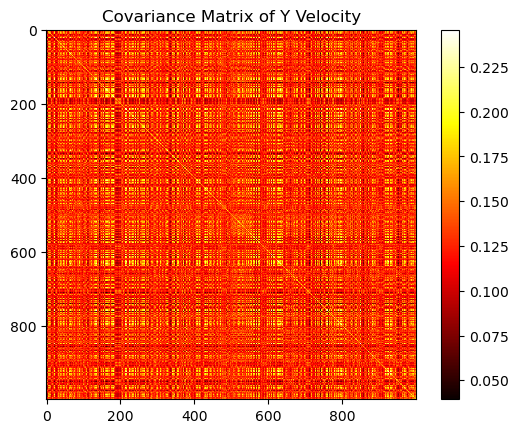

In [38]:
#plot covariance matrix
plt.imshow(x_covariance, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Covariance Matrix of Y Velocity')
plt.show()

In [39]:
def plot_column_scatterplot(A, col):
    for i in range(A.shape[1]):
        if A[i, col] != 0:
            plt.scatter(i, A[i, col], color='black')
    plt.show()

def plot_3d(points, theta, col):
    ax = plt.figure().add_subplot(projection='3d')
    mag = np.log10(np.abs(theta[:, col]))
    ax.scatter(points[:, 0], points[:, 2], mag)
    plt.show()

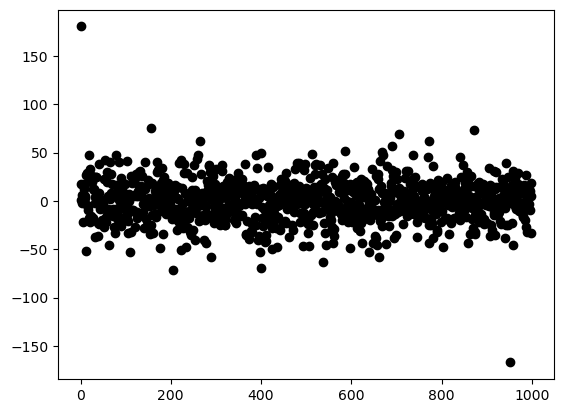

In [22]:
plot_column_scatterplot(np.linalg.cholesky(y_precision), 0)

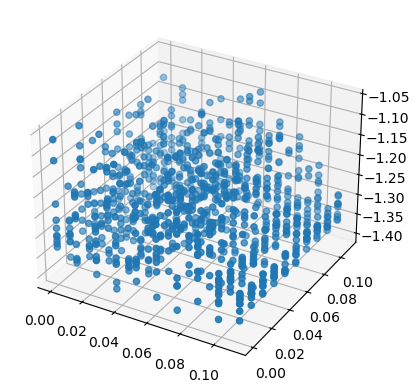

In [40]:
plot_3d(ordered_points, y_covariance, 0)

In [41]:
# sample every other timestep
half_data = data[::2, :, :]
half_z_velocity = half_data[:, :, -1]
half_x_velocity = half_data[:, :, 0]
half_y_velocity = half_data[:, :, 1]
half_x_covariance = np.cov(half_x_velocity, rowvar=False, bias=True)
half_y_covariance = np.cov(half_y_velocity, rowvar=False, bias=True)
half_z_covariance = np.cov(half_z_velocity, rowvar=False, bias=True)
# sample every 3rd timestep
third_data = data[::3, :, :]
third_x_velocity = third_data[:, :, 0]
third_y_velocity = third_data[:, :, 1]
third_z_velocity = third_data[:, :, -1]
third_x_covariance = np.cov(third_x_velocity, rowvar=False, bias=True)
third_y_covariance = np.cov(third_y_velocity, rowvar=False, bias=True)
third_z_covariance = np.cov(third_z_velocity, rowvar=False, bias=True)
# sample every 4th timestep
quarter_data = data[::4, :, :]
quarter_x_velocity = quarter_data[:, :, 0]
quarter_y_velocity = quarter_data[:, :, 1]
quarter_z_velocity = quarter_data[:, :, -1]
quarter_x_covariance = np.cov(quarter_x_velocity, rowvar=False, bias=True)
quarter_y_covariance = np.cov(quarter_y_velocity, rowvar=False, bias=True)
quarter_z_covariance = np.cov(quarter_z_velocity, rowvar=False, bias=True)

kl = kl_div(z_covariance, half_z_covariance)
print(kl)
kl = kl_div(z_covariance, third_z_covariance)
print(kl)
kl = kl_div(z_covariance, quarter_z_covariance)
print(kl)


0.8218628960466958
36.04462175986828
784.0090738872877


In [42]:
kl = kl_div(x_covariance, half_x_covariance)
print(kl)
kl = kl_div(x_covariance, third_x_covariance)
print(kl)
kl = kl_div(x_covariance, quarter_x_covariance)
print(kl)

1.4382764391048113
34.82746215431689
770.8405495908523


In [43]:
kl = kl_div(y_covariance, half_y_covariance)
print(kl)
kl = kl_div(y_covariance, third_y_covariance)
print(kl)
kl = kl_div(y_covariance, quarter_y_covariance)
print(kl)

1.484509157672619
47.573518683865586
874.7816386812456
